In [3]:
from sympy.printing.pretty.pretty_symbology import line_width
from torch.utils.data import DataLoader
!pip install plotly seaborn

   ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
   -- ------------------------------------- 1.0/14.8 MB 8.4 MB/s eta 0:00:02
   -------- ------------------------------- 3.1/14.8 MB 10.3 MB/s eta 0:00:02
   --------------- ------------------------ 5.8/14.8 MB 10.7 MB/s eta 0:00:01
   --------------------- ------------------ 8.1/14.8 MB 10.9 MB/s eta 0:00:01
   ----------------------------- ---------- 10.7/14.8 MB 11.2 MB/s eta 0:00:01
   ----------------------------------- ---- 13.1/14.8 MB 11.3 MB/s eta 0:00:01
   ---------------------------------------- 14.8/14.8 MB 11.1 MB/s eta 0:00:00


In [1]:
# general
import io

# data
import numpy as np
import pandas as pd

# machine learning
import torch
import torch.autograd as autograd  # computation graph
from torch import Tensor  # tensor node in the computation graph
import torch.nn as nn  # neural networks
import torch.nn.functional as F  # layers, activations and more
import torch.optim as optim  # optimizers e.g. gradient descent, ADAM, etc.
from tqdm import tqdm

# data visualization
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

In [2]:
chicago_taxi_dataset = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/chicago_taxi_train.csv")

In [3]:
training_df = chicago_taxi_dataset[["TRIP_MILES", "TRIP_SECONDS", "FARE", "COMPANY", "PAYMENT_TYPE", "TIP_RATE"]]

print("Read dataset completed successfully.")
print("Total number of rows: {0}\n\n".format(len(training_df.index)))
training_df.head(200)

Read dataset completed successfully.
Total number of rows: 31694




,TRIP_MILES,TRIP_SECONDS,FARE,COMPANY,PAYMENT_TYPE,TIP_RATE
0,2.57,2341,31.99,Flash Cab,Mobile,6.3
1,1.18,1074,9.75,Flash Cab,Credit Card,27.9
2,1.29,1173,10.25,Sun Taxi,Cash,0.0
3,3.70,3360,23.75,Choice Taxi Association,Cash,0.0
4,1.15,1044,10.00,Flash Cab,Cash,0.0
...,...,...,...,...,...,...
195,1.13,821,9.00,Blue Ribbon Taxi Association,Mobile,22.9
196,0.57,414,6.00,Flash Cab,Cash,0.0
197,1.22,886,9.00,City Service,Cash,0.0
198,1.68,1219,9.00,Sun Taxi,Mobile,23.0


In [4]:
training_df.describe(include="all")

,TRIP_MILES,TRIP_SECONDS,FARE,COMPANY,PAYMENT_TYPE,TIP_RATE
count,31694.000000,31694.000000,31694.000000,31694,31694,31694.000000
unique,NaN,NaN,NaN,31,7,NaN
top,NaN,NaN,NaN,Flash Cab,Credit Card,NaN
freq,NaN,NaN,NaN,7887,14142,NaN
mean,8.289463,1319.796397,23.905210,NaN,NaN,12.965785
std,7.265672,928.932873,16.970022,NaN,NaN,15.517765
min,0.500000,60.000000,3.250000,NaN,NaN,0.000000
25%,1.720000,548.000000,9.000000,NaN,NaN,0.000000
50%,5.920000,1081.000000,18.750000,NaN,NaN,12.200000
75%,14.500000,1888.000000,38.750000,NaN,NaN,20.800000


In [5]:
answer = '''
What is the maximum fare? 				              Answer: $159.25
What is the mean distance across all trips? 		Answer: 8.2895 miles
How many cab companies are in the dataset? 		  Answer: 31
What is the most frequent payment type? 		    Answer: Credit Card
Are any features missing data? 				          Answer: No
'''

# You should be able to find the answers to the questions about the dataset
# by inspecting the table output after running the DataFrame describe method.
#
# Run this code cell to verify your answers.

# What is the maximum fare?
max_fare = training_df['FARE'].max()
print("What is the maximum fare? \t\t\t\tAnswer: ${fare:.2f}".format(fare=max_fare))

# What is the mean distance across all trips?
mean_distance = training_df['TRIP_MILES'].mean()
print("What is the mean distance across all trips? \t\tAnswer: {mean:.4f} miles".format(mean=mean_distance))

# How many cab companies are in the dataset?
num_unique_companies = training_df['COMPANY'].nunique()
print("How many cab companies are in the dataset? \t\tAnswer: {number}".format(number=num_unique_companies))

# What is the most frequent payment type?
most_freq_payment_type = training_df['PAYMENT_TYPE'].value_counts().idxmax()
print("What is the most frequent payment type? \t\tAnswer: {type}".format(type=most_freq_payment_type))

# Are any features missing data?
missing_values = training_df.isnull().sum().sum()
print("Are any features missing data? \t\t\t\tAnswer:", "No" if missing_values == 0 else "Yes")

What is the maximum fare? 				Answer: $159.25
What is the mean distance across all trips? 		Answer: 8.2895 miles
How many cab companies are in the dataset? 		Answer: 31
What is the most frequent payment type? 		Answer: Credit Card
Are any features missing data? 				Answer: No


In [6]:
training_df.corr(numeric_only=True)

,TRIP_MILES,TRIP_SECONDS,FARE,TIP_RATE
TRIP_MILES,1.000000,0.800855,0.975344,-0.049594
TRIP_SECONDS,0.800855,1.000000,0.830292,-0.084294
FARE,0.975344,0.830292,1.000000,-0.070979
TIP_RATE,-0.049594,-0.084294,-0.070979,1.000000


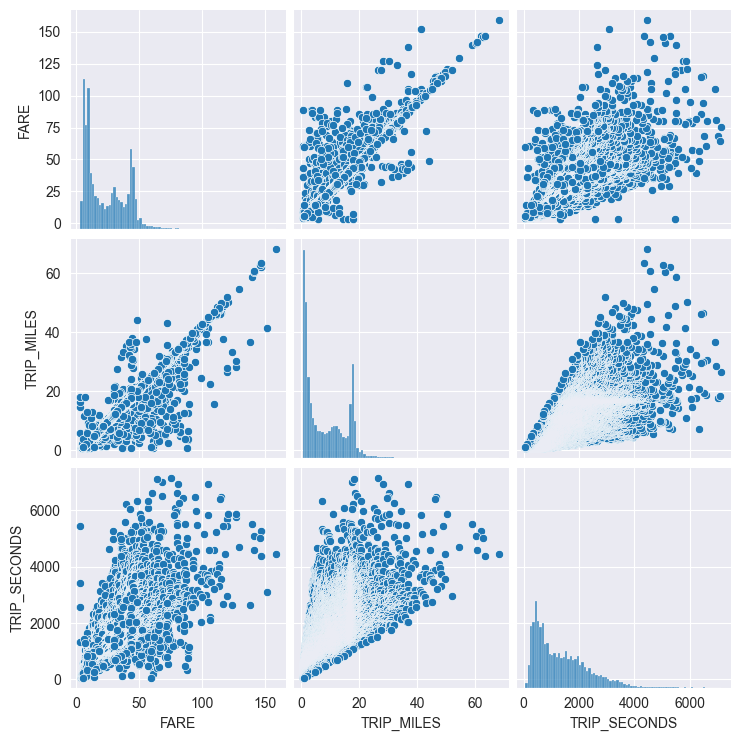

In [7]:
sns.pairplot(training_df, x_vars=["FARE", "TRIP_MILES", "TRIP_SECONDS"], y_vars=["FARE", "TRIP_MILES", "TRIP_SECONDS"])

In [8]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

In [9]:
import matplotlib.pyplot as plt
from typing import Dict, List


def plot_results(results: Dict[str, List[float]]):
    fig = plt.figure(figsize=(9, 9))
    train_loss = results["train_loss"]
    # test_loss = results["test_loss"]

    epochs = range(len(train_loss))

    fig.add_subplot(2, 1, 1)
    plt.plot(epochs, train_loss, label="train loss")
    # plt.plot(epochs, test_loss, label="test loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # fig.add_subplot(2, 1, 2)
    # plt.figure(figsize=(8, 4))
    # plt.plot(epochs, lr, label="learning rate")
    # plt.xlabel("Epochs")
    # plt.legend()

    plt.show()

In [30]:
# Hyperparameters
lr = 0.0001
epochs = 40
batch_size = 50

In [31]:
features = ["TRIP_MILES"]
label = "FARE"

X_train = torch.from_numpy(training_df[features].values.astype(np.float32))
y_train = torch.from_numpy(training_df[label].values.astype(np.float32)).reshape(-1, 1)

dataset = torch.utils.data.TensorDataset(X_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

model = LinearRegression(input_size=len(features), output_size=1).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

print(X_train.shape)
print(y_train.shape)

torch.Size([31694, 1])
torch.Size([31694, 1])


In [32]:
results = {
    "train_loss": [],
    "test_loss": []
}

for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0

    for _, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(X_train)
    results["train_loss"].append(train_loss)

100%|██████████| 40/40 [01:08<00:00,  1.70s/it]


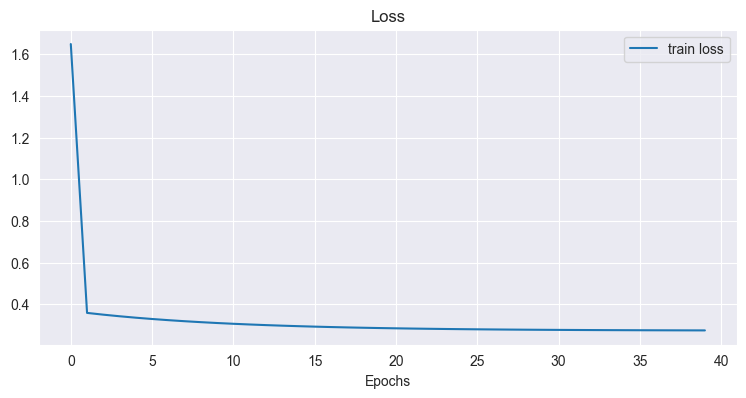

In [33]:
plot_results(results)

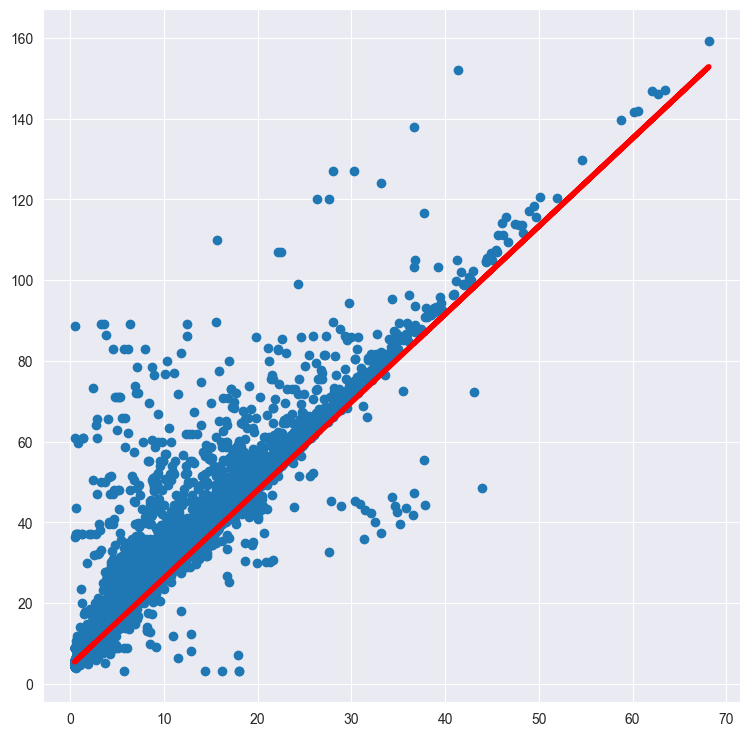

In [34]:
weights = []
biases = []
for name, param in model.named_parameters():
    if param.requires_grad:
        if "weight" in name:
            weights.append(param.data.item())
        else:
            biases.append(param.data.item())

with torch.inference_mode():
    model.cpu()
    y_pred = model(X_train).squeeze(1)

fig = plt.figure(figsize=(9, 9))
plt.scatter(X_train.numpy(), y_train.numpy(), label="data")
plt.plot(X_train.numpy(), y_pred, color="red", label="prediction", linewidth=4)